# CKP8366 - TÓPICOS AVANÇADOS - APRENDIZAGEM DE MÁQUINA PROBABILÍSTICA

<img  src="https://img.shields.io/badge/UFC_CKP8366-VAUX GOMES-000000?style=for-the-badge&logo=" /> <img src="https://img.shields.io/badge/Jupyter-000000?style=for-the-badge&logo=jupyter&logoColor=white" /> <img src="https://img.shields.io/badge/Python-000000?style=for-the-badge&logo=python&logoColor=white" />


In [1]:
%pip install --upgrade pip
%pip install torch # Pode demorar um pouco

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# Metrics
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

## Radial Basis Function Kernel

- Versão mais comum:
$$k(x_1, x_2) = \exp\left(-\frac{\|x_1 - x_2\|^2}{2\sigma^2}\right)$$

- O slide mostra uma versão ponderada (um pouco diferente)

> $$\displaystyle k(x_i, x_j) = \sigma^2 \exp \left(-\frac{1}{2} \sum_{d=1}^D w_d^2(x_{id} - x_{jd})^2\right)$$

## Gaussian Process

In [3]:
class GaussianProcessRBF:
  def __init__(self, sigma=1.0, noise=0.1, learning_rate=0.01, epochs=100):
    self.lr = learning_rate
    self.epochs = max(10, epochs) # Safety
    
    self.sigma = torch.tensor(sigma, dtype=torch.float32, requires_grad=True)
    self.noise = torch.tensor(noise, dtype=torch.float32, requires_grad=True)
  
  # RBF Kernel
  def kernel(self, xi, xj):
    # Safety
    xi = torch.tensor(xi, dtype=torch.float32) if not isinstance(xi, torch.Tensor) else xi
    xj = torch.tensor(xj, dtype=torch.float32) if not isinstance(xj, torch.Tensor) else xj
    
    #
    sqdist = torch.sum((xi.unsqueeze(1) - xj.unsqueeze(0))**2 * self.weights**2, dim=-1)
    return self.sigma**2 * torch.exp(-0.5 * sqdist)
  
  # 
  def fit(self, X, y, verbose=False):
    # Train data is required for prediction  :-(
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.float32)
    
    #
    self.weights = torch.randn(self.X.shape[1], dtype=torch.float32, requires_grad=True)
    
    #
    optim = torch.optim.Adam([self.sigma, self.noise, self.weights], lr=self.lr)
    
    # Epochs
    for e in range(self.epochs):
      # Gradient reset
      optim.zero_grad()
      
      #
      K = self.kernel(self.X, self.X) + self.noise**2 * torch.eye(len(self.X))
      loss = torch.mean(torch.logdet(K) + self.y.T @ torch.linalg.solve(K, self.y)) # solve == inv
      
      #
      loss.backward()
      optim.step()
      
      if verbose:
        print(f'Epoch: {e}', end='\r')
    
    #
    self.K_inv = torch.linalg.solve(
      self.kernel(self.X, self.X) + self.noise**2 * torch.eye(len(X)), self.y) # solve == inv
  
  def predict(self, X):
    X = torch.tensor(X, dtype=torch.float32) # (500, 1)

    K_ = self.kernel(self.X, X)  # (n_test, n_train)
    K__ = self.kernel(X, X) + self.noise**2 * torch.eye(len(X))  # (n_test, n_test)

    # Aqui dá um erro escabroso
    if K_.ndim == 1:
        K_ = K_.reshape(-1, 1)

    mu = K_.T @ self.K_inv  # (n_test, n_train) @ (n_train, 1) -> (n_test, 1)
    cov = K__ - K_.T @ torch.linalg.solve(self.kernel(self.X, self.X) + self.noise**2 * torch.eye(len(self.X)), K_) # (n_test, n_test)

    sigma = torch.sqrt(torch.diag(cov))  # (n_test,)

    return mu.detach().numpy(), sigma.detach().numpy()

  def code(self):
    return f'GPE{self.epochs}S{self.X.shape[0]}'
  
  def __str__(self):
    return f'GaussianProcessRBF: \n(epochs → {self.epochs}) (size → {self.X.shape[0]})'

#### Carregamento dos dados

In [4]:
def prepare_data(path, delimiter=','):
  # Data
  data = np.genfromtxt(path, delimiter=delimiter)

  # Separation
  X = data[:, :-1]
  y = data[:, -1:]

  # Normalization 
  X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))           # MinMax  0 ~ 1
  y = 2  * (y - y.min(axis=0)) / (y.max(axis=0) - y.min(axis=0)) - 1  # MinMax -1 ~ 1            

  return X, y

#
X_train, y_train = prepare_data('./files/gp_data_train.csv')
X_test,  y_test  = prepare_data('./files/gp_data_test.csv')

#
X_train.shape, y_train.shape, X_test.shape,  y_test.shape

((100, 1), (100, 1), (500, 1), (500, 1))

#### Treinamento

In [9]:
def run(X_train, y_train, X_test, y_test, sigma=1.0, noise=0.1, learning_rate=0.01, epochs=1000, train_sizes=None, verbose=False):
  if train_sizes is None:
    train_sizes = [X_train.shape[0]]
    
  models = []
  metrics = {
    'model': [],
    'rmse': [],
    'nlpd': [] # Negative Log Predictive Density
  }
  
  #
  for i, s in enumerate(train_sizes):
    if verbose:
      print(f' → Running {i+1} of {len(train_sizes)}')
    
    # Training 
    model = GaussianProcessRBF(sigma=sigma, noise=noise, learning_rate=learning_rate, epochs=epochs)
    %time model.fit(X_train[:s, :], y_train[:s, :], verbose=verbose)
    
    # Prediction
    y_hat, _ = model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_hat))
    nlpd = -np.mean(norm.logpdf(y_test, loc=y_test, scale=sigma))
    
    #
    models.append(model)
    
    #
    metrics['model'].append(model.code())
    metrics['rmse'].append(rmse)
    metrics['nlpd'].append(nlpd)
    
  #
  return models, metrics


models, metrics = run(X_train, y_train, X_test, y_test, train_sizes=[10,30,50,75,100], epochs=2000, verbose=True)

 → Running 1 of 5
CPU times: user 959 ms, sys: 11.1 ms, total: 970 ms
Wall time: 1.01 s
 → Running 2 of 5
CPU times: user 1.5 s, sys: 50.1 ms, total: 1.55 s
Wall time: 961 ms
 → Running 3 of 5
CPU times: user 4 s, sys: 224 ms, total: 4.22 s
Wall time: 1.07 s
 → Running 4 of 5
CPU times: user 7.28 s, sys: 1.01 s, total: 8.29 s
Wall time: 2.19 s
 → Running 5 of 5
CPU times: user 7.68 s, sys: 938 ms, total: 8.62 s
Wall time: 2.3 s


#### Plotting stuff

In [6]:
def plot(model, X_test, y_test=None):
  # Safety
  if not hasattr(model, 'weights'):
    raise Exception('Model is not trained')
  
  # Prediction
  y_hat, sigma = model.predict(X_test)
  
  # Config
  plt.figure(figsize=(8, 5))

  # Test
  if y_test is not None:
    plt.scatter(X_test, y_test, c='orange', marker='*', alpha=0.5, label='Test data')      
  
  # Train
  plt.scatter(model.X.numpy(), model.y.numpy(), c='red', label='Training data')      
  
  # Prediction
  plt.plot(X_test, y_hat, 'blue', label='Prediction')
  plt.fill_between(
    X_test.ravel(), y_hat.ravel() - 2*sigma, y_hat.ravel() + 2*sigma, 
    alpha=0.2, color='blue', label=r'$\hat{\mu} \pm 2\hat{\sigma}$'
  )
  
  #
  plt.xlabel('X')
  plt.ylabel('y')
  
  plt.title(str(model))
  plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
  
  plt.show()

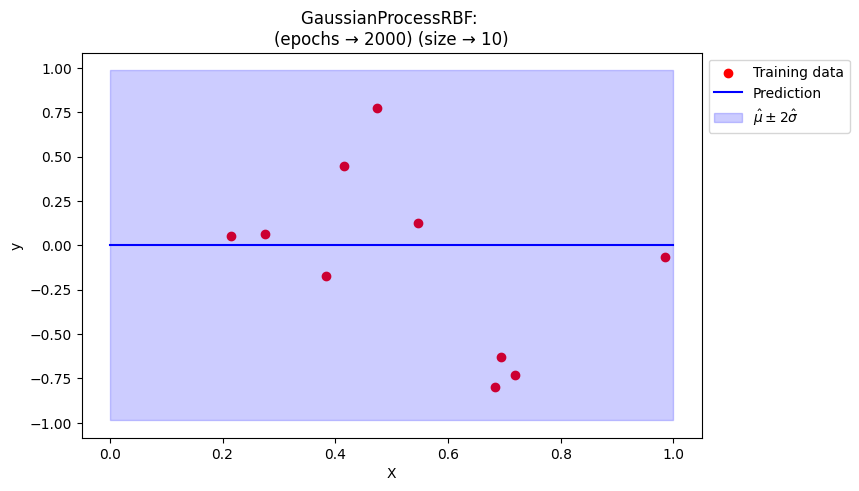

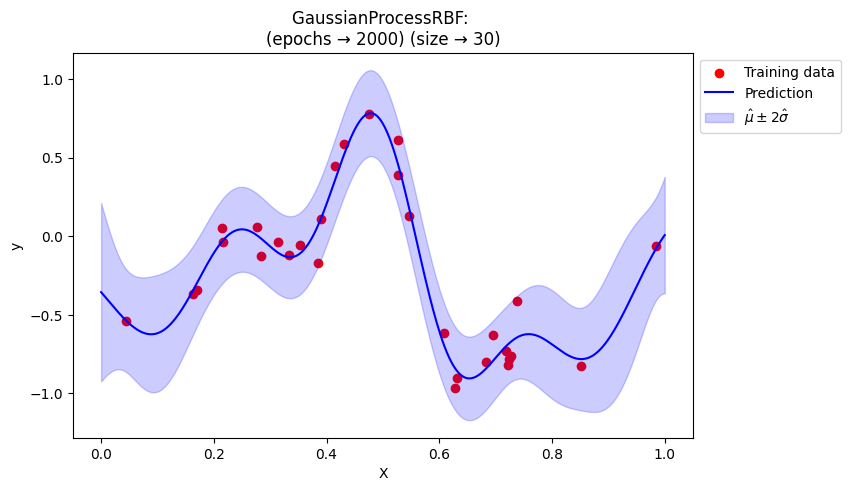

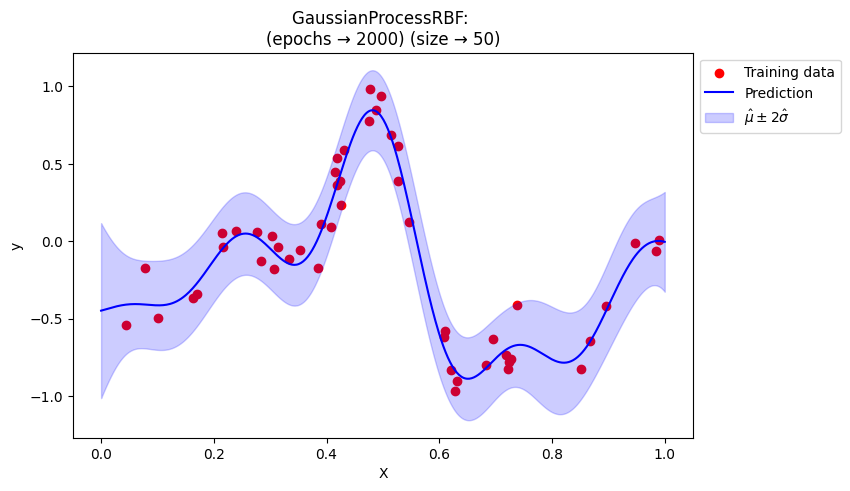

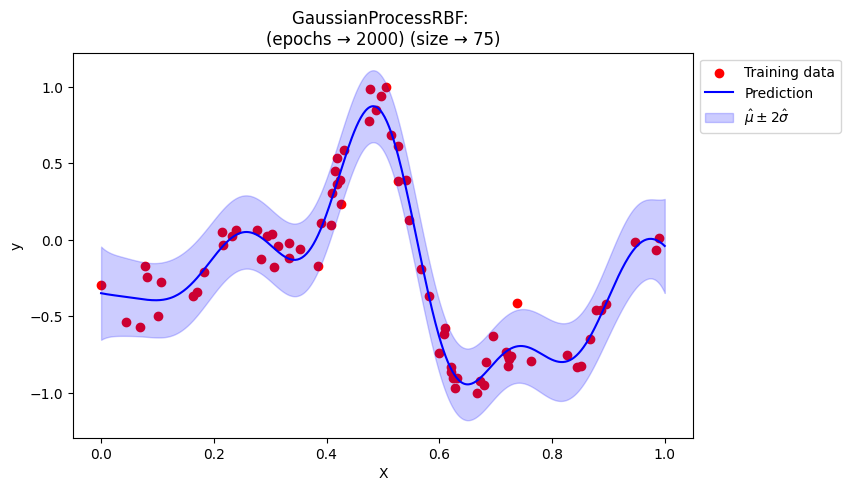

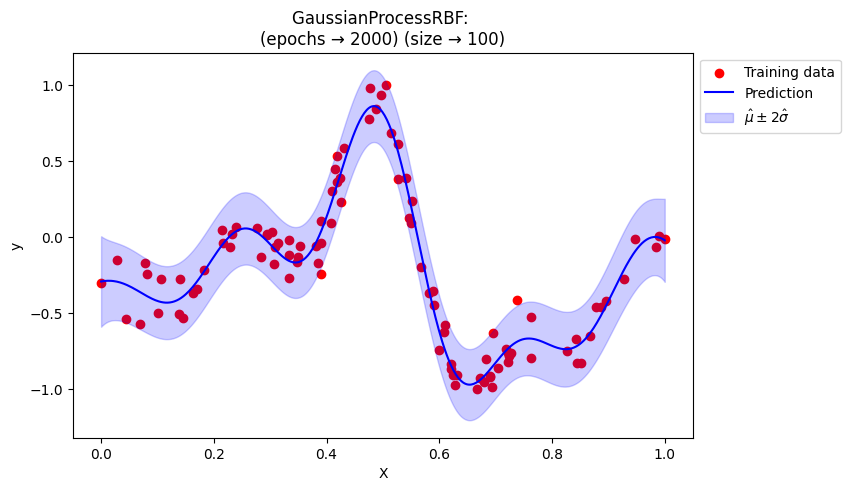

In [7]:
for model in models:
  plot(model, X_test=X_test) # O primeiro ficou meio estranho

#### Métrics

In [10]:
pd.DataFrame(metrics, columns=['model', 'rmse', 'nlpd'])


,model,rmse,nlpd
0,GPE2000S10,0.440862,0.918939
1,GPE2000S30,0.211551,0.918939
2,GPE2000S50,0.155436,0.918939
3,GPE2000S75,0.156521,0.918939
4,GPE2000S100,0.146692,0.918939
